In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers  import Concatenate
from tensorflow.keras.layers import AveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from keras.preprocessing import image
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
import urllib.request
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from keras.layers import Input, Add, Dense,GlobalAvgPool2D, Concatenate, AvgPool2D, Dropout, ReLU, Activation, MaxPool2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam


In [34]:
# plant_village = Dataset("/kaggle/input/plant-village-dataset/PlantVillageDataset/PlantVillage/PlantVillage")

import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1


In [35]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf

class DataSplit:

    def __init__(self, dataset_path: str, train_path: str, test_path: str, val_path: str) -> None:
        self.PARENT = dataset_path
        self.TRAIN_DIR = train_path
        self.TEST_DIR = test_path
        self.VAL_DIR = val_path
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None

    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )
        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )
        self.val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

    def create_splits(self, dataset_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
        classes = os.listdir(dataset_path)
        os.makedirs(output_path, exist_ok=True)

        for split in ["train", "val", "test"]:
            os.makedirs(os.path.join(output_path, split), exist_ok=True)

        for class_name in classes:
            class_path = os.path.join(dataset_path, class_name)
            images = os.listdir(class_path)
            train, test_val = train_test_split(images, train_size=train_ratio, random_state=42)
            val, test = train_test_split(test_val, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

            for split_name, split_data in zip(["train", "val", "test"], [train, val, test]):
                split_path = os.path.join(output_path, split_name, class_name)
                os.makedirs(split_path, exist_ok=True)
                for img in split_data:
                    shutil.copy(os.path.join(class_path, img), os.path.join(split_path, img))

    def get_images(self):
        gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
        return (
            gen.flow_from_directory(self.TRAIN_DIR, target_size=(75, 75), batch_size=32, class_mode='categorical', shuffle=True, seed=42),
            gen.flow_from_directory(self.VAL_DIR, target_size=(75, 75), batch_size=32, class_mode='categorical', shuffle=True, seed=42),
            gen.flow_from_directory(self.TEST_DIR, target_size=(75, 75), batch_size=32, class_mode='categorical', shuffle=False, seed=42)
        )

dataset_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/PlantVillage"
output_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage/split_dataset"

train_path = output_path + "/train"
val_path = output_path + "/val"
test_path = output_path + "/test"

ds = DataSplit(dataset_path, train_path, test_path, val_path)
ds.create_splits(dataset_path, output_path)
train_images, val_images, test_images = ds.get_images()


Found 14440 images belonging to 15 classes.
Found 4128 images belonging to 15 classes.
Found 2070 images belonging to 15 classes.


# Read Data

In [36]:
image_path= output_path + "/train"

In [37]:
train_path = output_path + "/train"
val_path = output_path + "/val"
test_path = output_path + "/test"

# Visualize Images

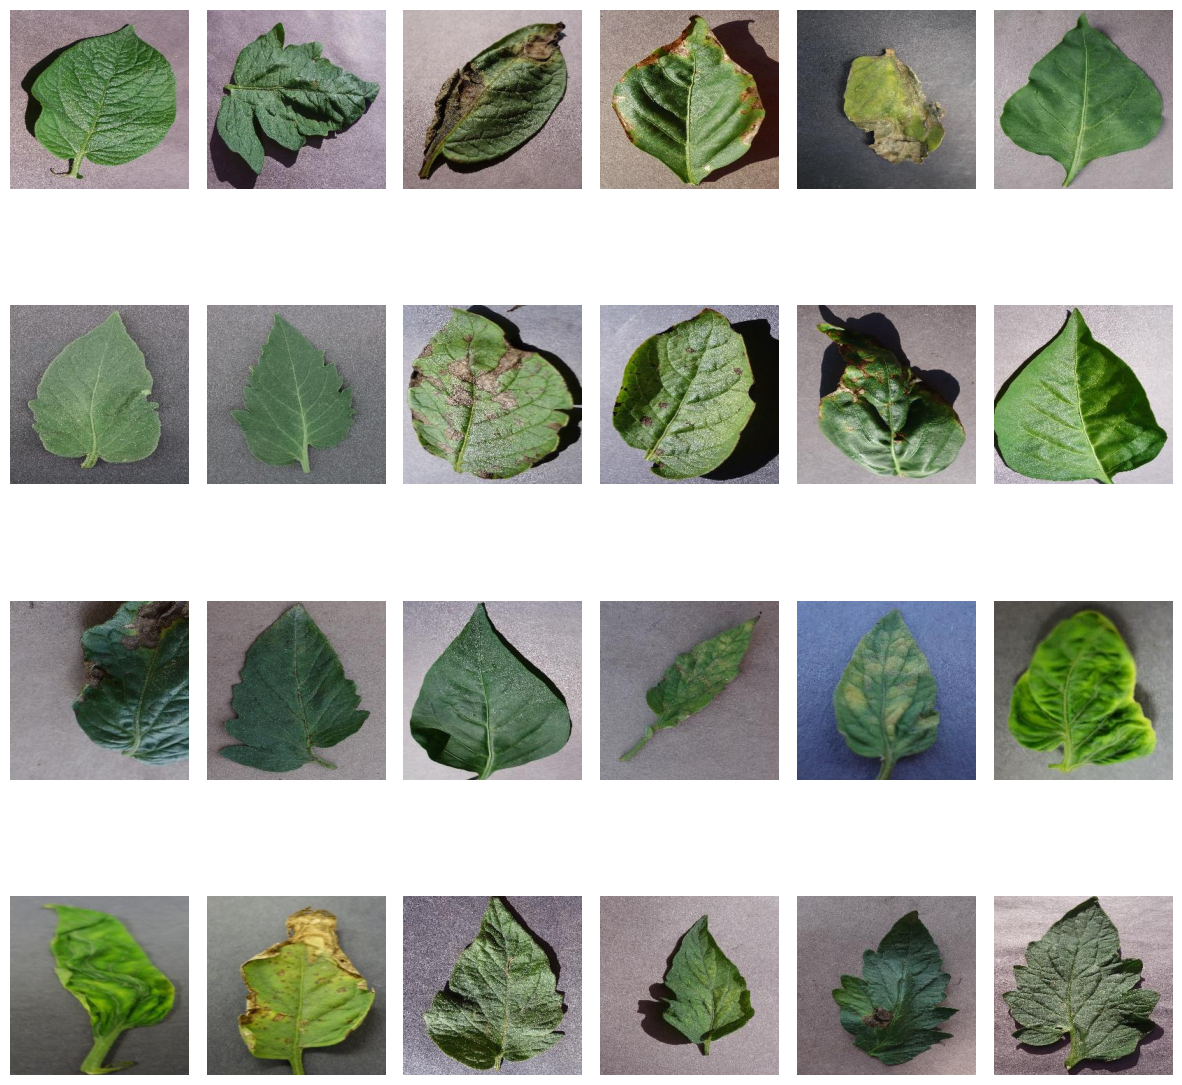

In [38]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(24):
    random_folder=np.random.randint(0,len(os.listdir(image_path)))
    random_folder_path=os.path.join(image_path,os.listdir(image_path)[random_folder])
    random_image=np.random.randint(0,len(os.listdir(random_folder_path)))
    random_image_path=os.path.join(random_folder_path,os.listdir(random_folder_path)[random_image])
    image=cv2.imread(random_image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.subplot(4,6,i+1)
    plt.imshow(image)
    plt.axis("off")
plt.show()

number_class

In [39]:
class_names = os.listdir(image_path)
print(class_names)

['Tomato__Tomato_YellowLeaf__Curl_Virus', 'Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_healthy', 'Tomato_Septoria_leaf_spot', 'Potato___Late_blight', 'Tomato_Leaf_Mold', 'Tomato__Target_Spot', 'Potato___Early_blight', 'Tomato_Bacterial_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Pepper__bell___healthy', 'Tomato__Tomato_mosaic_virus', 'Tomato_Early_blight', 'Tomato_Late_blight']


In [40]:
print("Number of classes : {}".format(len(class_names)))

Number of classes : 15


Number of images in each class

In [41]:
number_of_images = {}
for class_name in class_names:
    number_of_images[class_name] = len(os.listdir(image_path+"/"+class_name))

images_each_class = pd.DataFrame(list(number_of_images.items()), columns=['Class Name', 'Number of Images'])


In [42]:
images_each_class

,Class Name,Number of Images
0,Tomato__Tomato_YellowLeaf__Curl_Virus,2246
1,Pepper__bell___Bacterial_spot,697
2,Potato___healthy,106
3,Tomato_healthy,1113
4,Tomato_Septoria_leaf_spot,1239
5,Potato___Late_blight,700
6,Tomato_Leaf_Mold,666
7,Tomato__Target_Spot,982
8,Potato___Early_blight,700
9,Tomato_Bacterial_spot,1488


<ipython-input-43-5265a1f170c0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Class Name', x='Number of Images', data=images_each_class,palette="tab20")


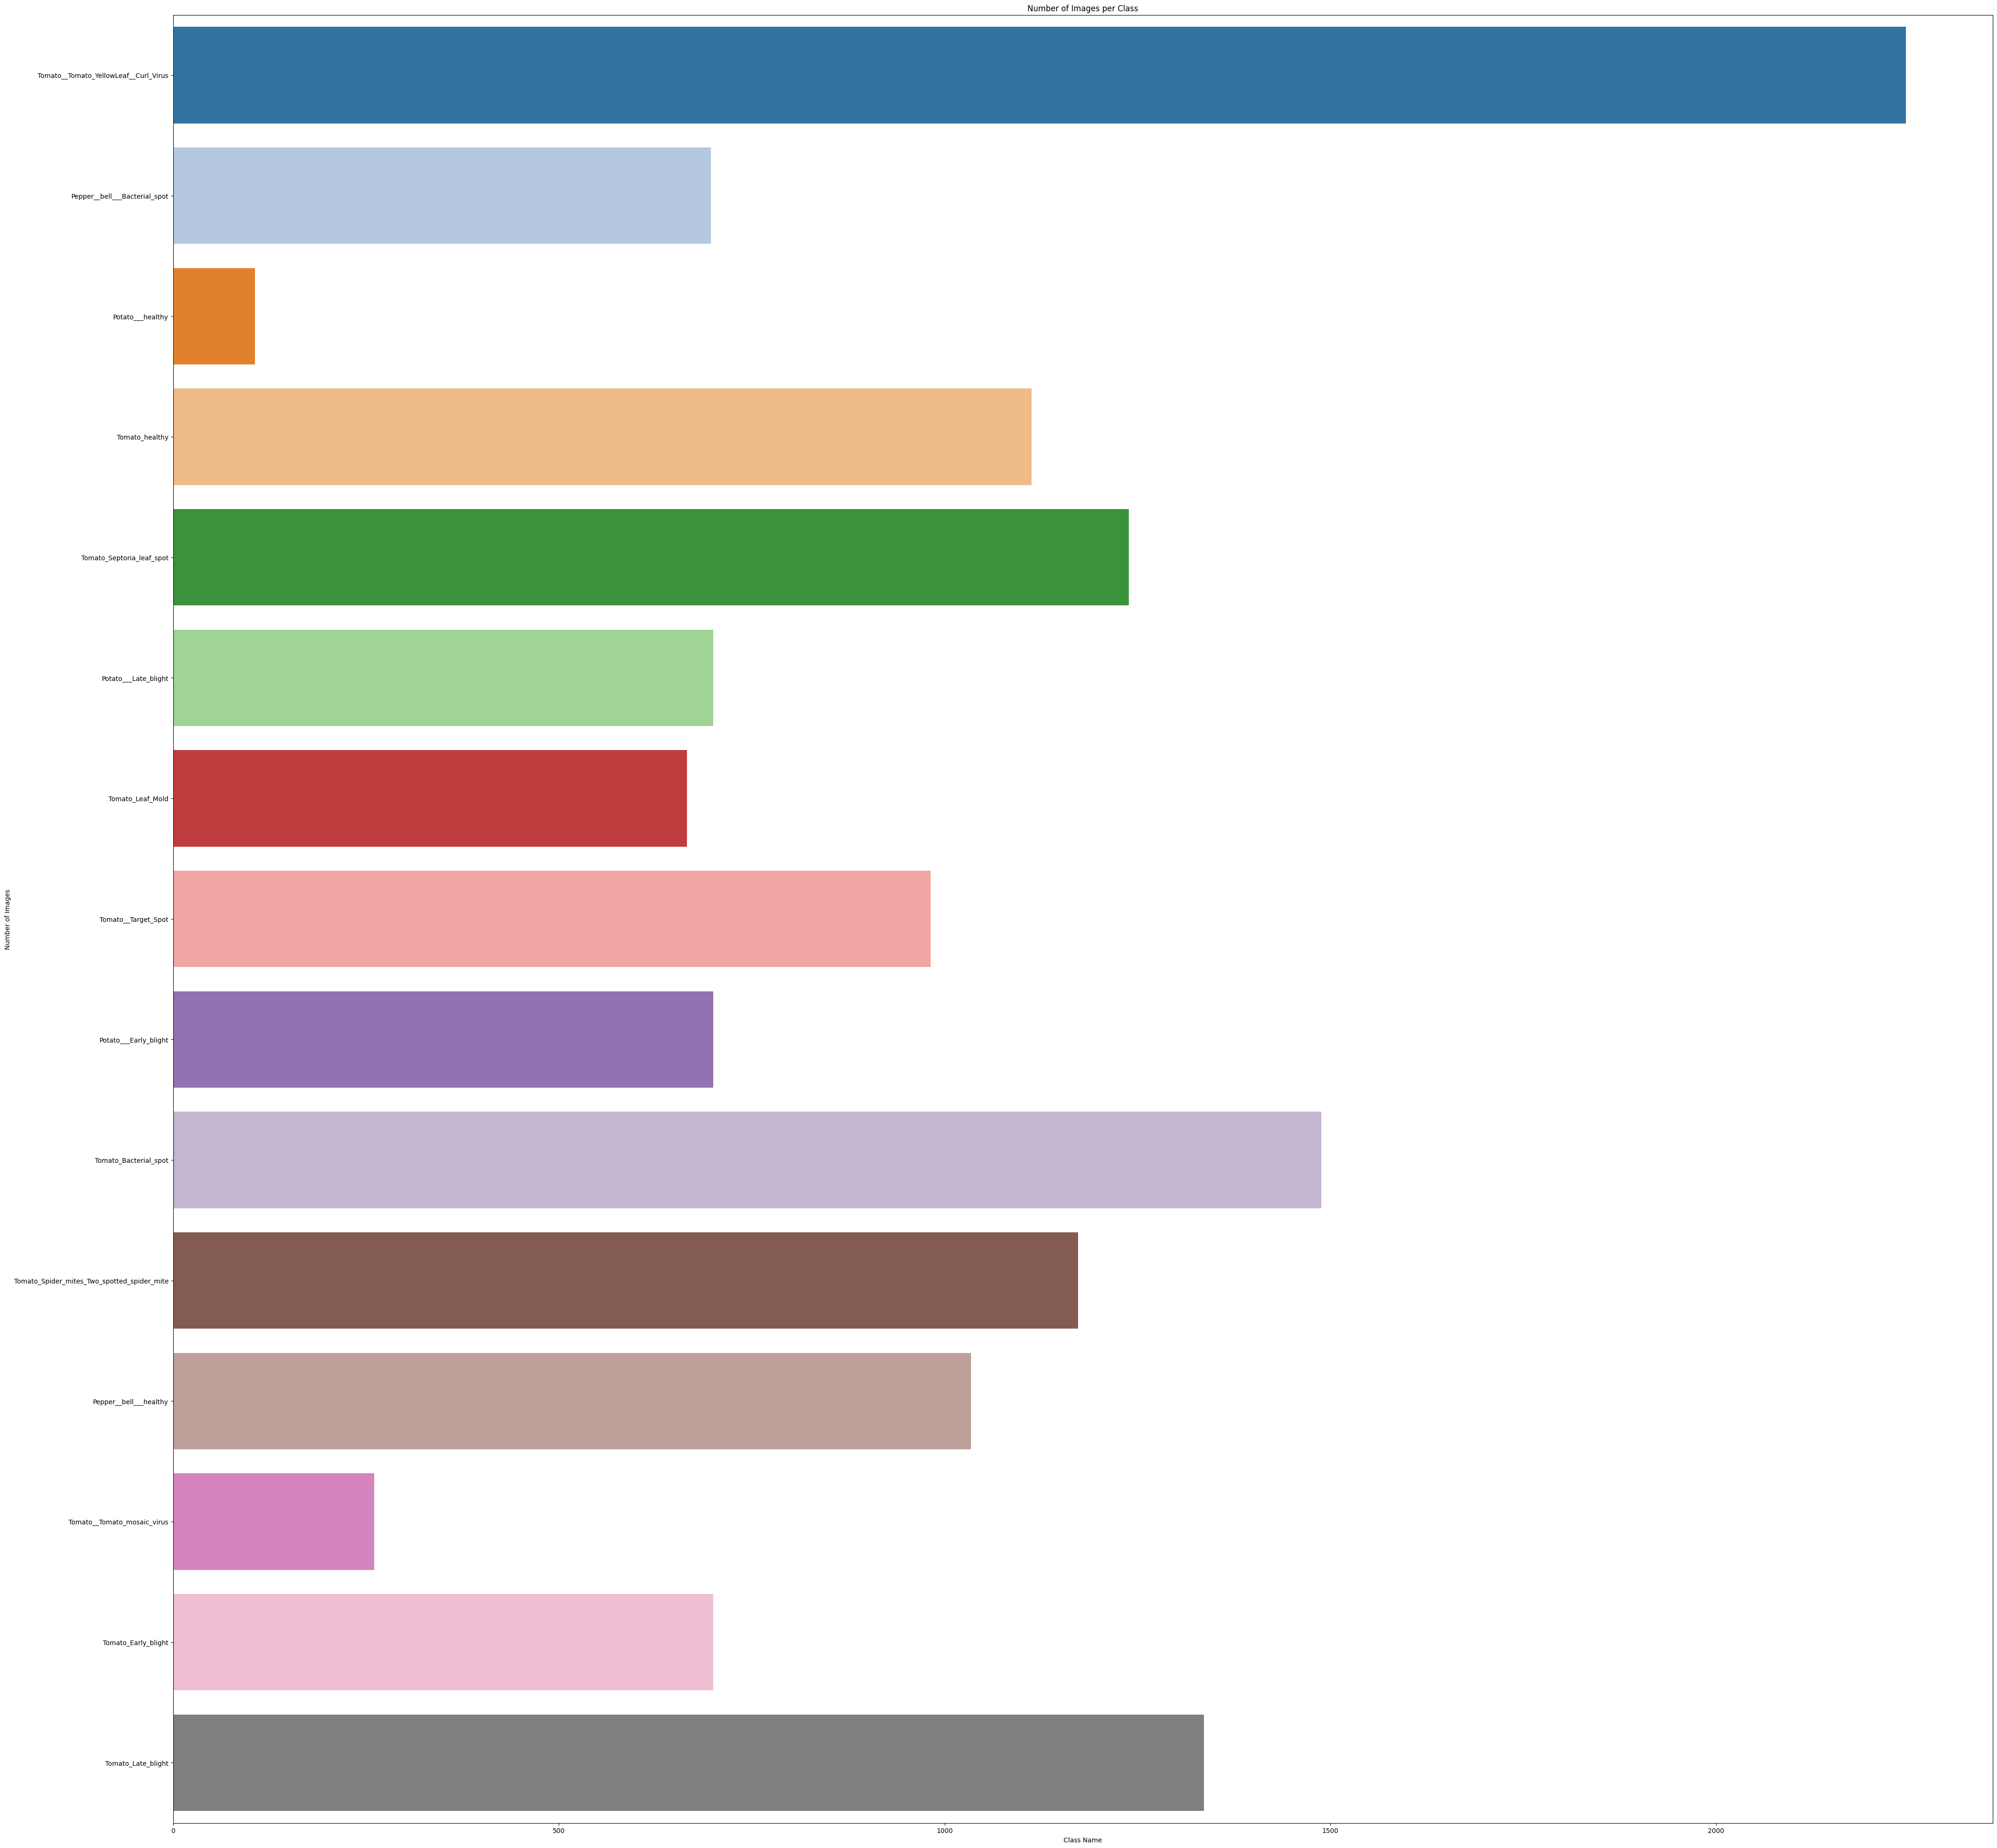

In [43]:
plt.figure(figsize=(50,50))
sns.barplot(y='Class Name', x='Number of Images', data=images_each_class,palette="tab20")
plt.title('Number of Images per Class')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.show()

In [44]:
batch_size=20

train_data,valid_data and test_data Generator

In [45]:
traindata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,
                                                                    shear_range=0.2, horizontal_flip=True,validation_split=0.2,fill_mode='nearest')

validdata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testdata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [46]:
train_data_generator=traindata_generator.flow_from_directory(train_path,batch_size=batch_size,class_mode="categorical",
                                                           target_size=(224,224),color_mode="rgb",shuffle=True )

Found 14440 images belonging to 15 classes.


In [47]:
valid_data_generator=validdata_generator.flow_from_directory(train_path,batch_size=batch_size,class_mode="categorical",
                                                           target_size=(224,224),color_mode="rgb",shuffle=True)

Found 14440 images belonging to 15 classes.


In [48]:
test_data_generator=testdata_generator.flow_from_directory(test_path,batch_size=batch_size,class_mode="categorical",
                                                           target_size=(224,224),color_mode="rgb",shuffle=False )

Found 2070 images belonging to 15 classes.


In [49]:
class_dict = train_data_generator.class_indices
class_list = list(class_dict.keys())
class_list

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [50]:
train_number=train_data_generator.samples
valid_number=valid_data_generator.samples

# Create MobileNetV2 Model

In [51]:
mobilenetV2_model= tf.keras.applications.MobileNetV2(weights='imagenet',classes=15,include_top=False, input_shape=(224,224, 3))
x= mobilenetV2_model.output
x= GlobalAveragePooling2D()(x)
x= Dense(1024,activation='relu')(x)
x= Dense(512,activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.2)(x)
prediction= Dense(15, activation = 'softmax')(x)
model= Model(inputs= mobilenetV2_model.input, outputs= prediction)

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 4,104,271 (15.66 MB)

 Trainable params: 4,069,135 (15.52 MB)

 Non-trainable params: 35,136 (137.25 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 4,104,271 (15.66 MB)

 Trainable params: 4,069,135 (15.52 MB)

 Non-trainable params: 35,136 (137.25 KB)

In [52]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

In [53]:
history= model.fit(train_data_generator,
                   steps_per_epoch=train_number//batch_size,
                   validation_data= valid_data_generator,
                   validation_steps= valid_number//batch_size,
                   shuffle=True,

                   epochs =20,
                   batch_size = 20,callbacks=[callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 250s 286ms/step - accuracy: 0.7385 - loss: 0.8676 - val_accuracy: 0.1652 - val_loss: 21.8194
Epoch 2/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 240s 281ms/step - accuracy: 0.9002 - loss: 0.3237 - val_accuracy: 0.2422 - val_loss: 10.2589
Epoch 3/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 203s 281ms/step - accuracy: 0.9190 - loss: 0.2598 - val_accuracy: 0.1579 - val_loss: 6.3466
Epoch 4/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 205s 284ms/step - accuracy: 0.9246 - loss: 0.2340 - val_accuracy: 0.5796 - val_loss: 2.7964
Epoch 5/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 260s 282ms/step - accuracy: 0.9435 - loss: 0.1775 - val_accuracy: 0.6163 - val_loss: 2.6426
Epoch 6/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 200s 276ms/step - accuracy: 0.9442 - loss: 0.1718 - val_accuracy: 0.4397 - val_loss: 6.0911
Epoch 7/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 200s 277ms/step - accuracy: 0.9490 - loss: 0.1573 - val_accuracy: 0.7630 - val_loss: 1.2034
Epoch 8/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 200s 277ms/step - accuracy: 0.9451

# Summarize History For Accuracy

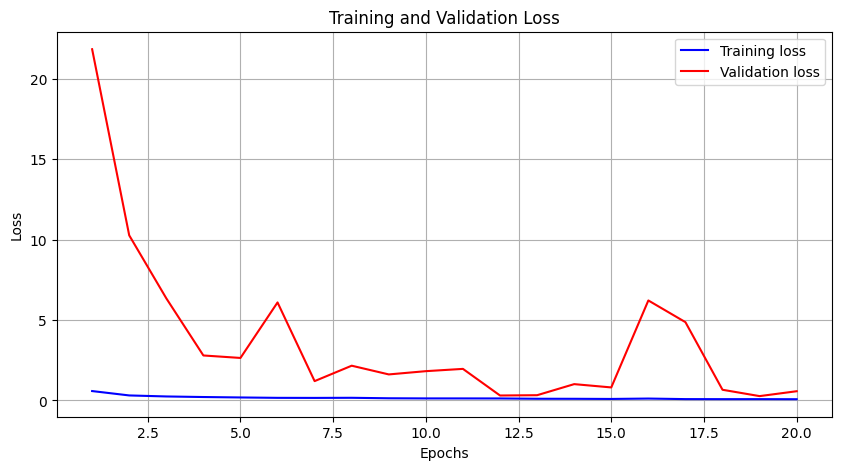

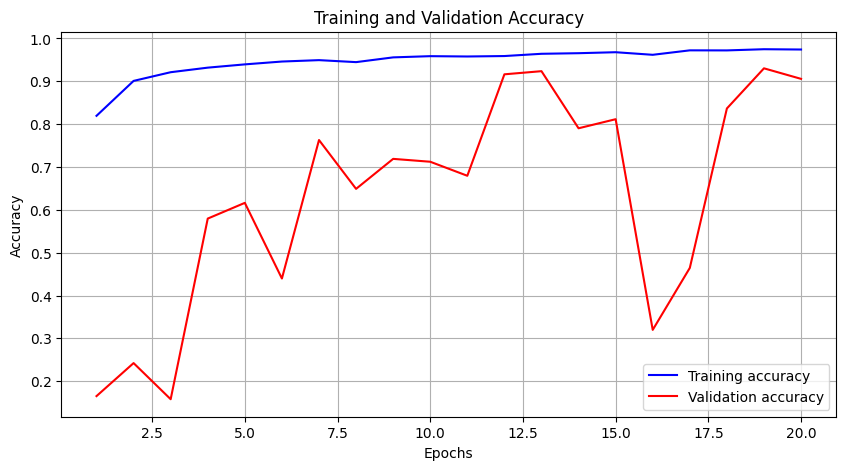

In [60]:
import matplotlib.pyplot as plt

# Get the training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, 'b', label='Training loss')
plt.plot(epochs, validation_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Save And Load Model

In [61]:
# Assuming your model object is called 'model'
model.save('MobileNet_V2.h5')
model = load_model('MobileNet_V2.h5')


104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step


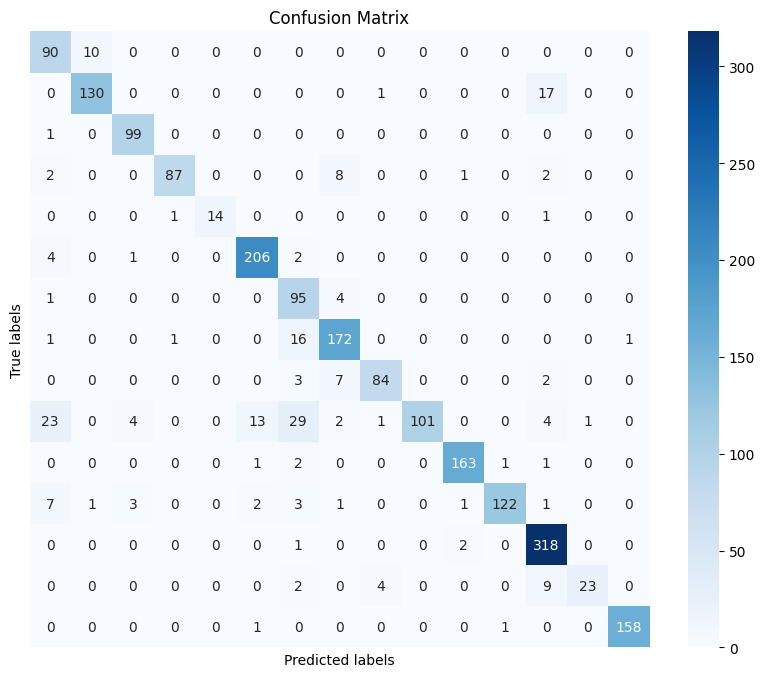

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test dataset
predictions = model.predict(test_data_generator)

# Get the true labels
true_labels = test_data_generator.classes

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define the classes
classes = sorted(test_data_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=False, yticklabels=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get true labels and predicted labels
true_labels = test_data_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='macro')

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.8995169082125604
Precision: 0.9129848422822634
Recall: 0.8794905003233524
F1-score: 0.8853405082454514


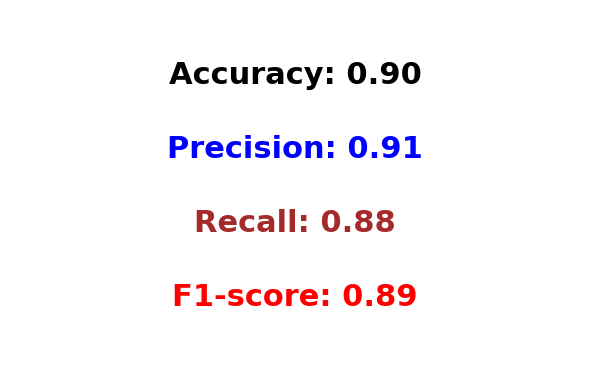

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Create a blank figure
fig, ax = plt.subplots(figsize=(6, 4))

# Hide axes
ax.axis('off')

# Display metrics with different colors
ax.text(0.5, 0.8, f'Accuracy: {accuracy:.2f}', ha='center', fontsize=22, fontweight='bold', color='black')
ax.text(0.5, 0.6, f'Precision: {precision:.2f}', ha='center', fontsize=22, fontweight='bold', color='blue')
ax.text(0.5, 0.4, f'Recall: {recall:.2f}', ha='center', fontsize=22, fontweight='bold', color='brown')
ax.text(0.5, 0.2, f'F1-score: {f1:.2f}', ha='center', fontsize=22, fontweight='bold', color='red')

# Adjust layout
fig.tight_layout()

# Save the figure
plt.savefig('metrics.png')

# Show the figure
plt.show()

In [59]:
# from tensorflow.keras.utils import plot_model

# # Plot the model architecture and save it as an image
# plot_model(model, to_file='model_architecture.png', show_shapes=False, show_layer_names=False,expand_nested=False)
